## Load Modules

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import h5py
import mne
mne.set_log_level("CRITICAL")
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)

from time import time

plt.rcParams["figure.figsize"] = (16,8)

In [81]:
class ELT_rec:
    """
    Extract Load Transform for the batch of tracks of a whole recording
    
    """
    def __init__(self, fname):
        assert fname != "" and fname is not None
        self.fname = fname
        self.data = self.load_data()
        #instead of giving a track_id == None, we set the initial track as a default value
        self.elt_track = ELT_track(self.data, 0)
        self.elt_track.fname = fname #handling an internal error
        
    def load_data(self):
        assert self.fname != "" and self.fname is not None
        f = h5py.File(self.fname,'r')
        data = f.get('y')
        data = np.array(data)
        # col 0 is the time, sampled at 250 samples per second
        # col -1 is all 11, we'll drop it
        # col -2 is the trigger
        data = data[:, 1:-1]
        data[:, -1] -= 1 #useful for sign changes
        return data

    def clean_single_track(self, track_id):
        """
        For a given EEG measurement as .mat file, clean the track_id-th track
        
        track_id : int in [0, 19]
        """
        self.elt_track.track_id = track_id
        return self.elt_track.clean_data(self.data)
    
    def clean_all_tracks(self):
        """
        Perform the cleaning operation over all tracks for a recording
        
        After this operation tracks have to be aligned
        """
        cleaned_tracks = []
        for track_id in range(0,19):
            cleaned_tracks.append(self.clean_single_track(track_id))
        self.cleaned_tracks = cleaned_tracks
        return cleaned_tracks 
    
    def align_cleaned_tracks(self):
        if self.cleaned_tracks == [] or self.cleaned_tracks is None:
            self.clean_all_tracks()
        
        min_len = min([track.shape[1] for track in self.cleaned_tracks])
        for track in self.cleaned_tracks:
            diff = track.shape[1] - min_len
            a,b = (diff // 2 + 1), (diff // 2)
            track = np.expand_dims(track[:, a:-b], 0)
        self.aligned_tracks = np.vstack(self.cleaned_tracks)
        
        
    
class ELT_track:
    """
    Extract Load Transform for a single track, for a single person
    """
    def __init__(self, track, track_id):
        self.n_channels = 32 #32 channels
        self.s_freq = 250 #250 sample per second
        self.ch_types = ['eeg'] * self.n_channels #all eegs'
        self.track = track
        self.track_id = track_id
        self.start, self.stop = self.extract_trigger_intervals(track)
        assert self.track_id >= 0 and self.track_id < 20
        
    def extract_trigger_intervals(self, data):
        """
        Extract a list of tuples that contain respectively the start and the stop of the trigger. -- deprecated
        Extract the start & stop time intervals for a given track id in [0, 19]
        """
        
        assert self.track_id >= 0 and self.track_id < 20
        signchange = ((np.roll(data[:, -1], 1) - data[:, -1]) != 0).astype(int)
        trig = np.where(signchange == 1)[0]
        trig_coupled = np.array([(trig[i], trig[i+1]) for i in range(0, len(trig)-1, 2)])
        return trig_coupled[self.track_id][0], trig_coupled[self.track_id][1]
    
    def prepare_data(self, data):
        """
        data_trim: Signal in a single sample period (30s) as (n_samples x channels) ndarray
        """
        
        montage = mne.channels.make_standard_montage('biosemi32')
        data_info = mne.create_info(ch_names=montage.ch_names, 
                                    sfreq=self.s_freq, 
                                    ch_types=self.ch_types, 
                                    verbose=True) 

        #data_mne_raw = mne.io.RawArray(data.T, data_info) # --probably obsolete
        #data_mne_raw._filenames = [self.fname.split('/')[-1]] #avoid annoying errors --probably obsolete

        data_filtered = mne.filter.filter_data(data.T, 
                                               self.s_freq, 
                                               l_freq=1.0, h_freq=None, 
                                               picks=None) #HPF

        data_mne_filtered = mne.io.RawArray(data_filtered, data_info)                    
        data_mne_filtered._filenames = [self.fname.split('/')[-1]]#avoid annoying errors
        
        new_names = dict(
            (ch_name,
             ch_name.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp'))
            for ch_name in data_mne_filtered.ch_names)
        data_mne_filtered.rename_channels(new_names)
        
        
        data_mne_filtered.set_montage(montage)
        data_mne_filtered.set_eeg_reference(projection=True)  # needed for inverse modeling
        return data_mne_filtered
    
    
    def run_ica(self, data, method, n_components, fit_params=None):
        ica = ICA(n_components=n_components, method=method, fit_params=fit_params,
                  max_iter=1200, random_state=0, verbose=False)
        t0 = time()
        ica.fit(data)
        fit_time = time() - t0
        title = ('ICA decomposition using %s (took %.1fs)' % (method, fit_time))
        return ica
    
    def clean_data(self, data, n_components=16, verbose=False):
        """
        DOC
        """
        
        t0 = time()
        #restrict the time serie domain to [start, stop)
        #trigger is useless from now on
        self.start, self.stop = self.extract_trigger_intervals(self.track)
        data_trim = data[self.start:self.stop+1, :-1] 
        #NEEDED HPF filter for ICA
        data_mne_filtered = self.prepare_data(data_trim).filter(1.0, None)
        ica = self.run_ica(data_mne_filtered, 'fastica', n_components)  
        data_copy = data_mne_filtered.copy()
        ica.apply(data_copy)
        if verbose:
            self.show_projection(data_mne_filtered, ica)
            plt.plot(data_trim[:, 0], label='original')
            plt.plot(data_copy.get_data()[0, :], label='clean')
            plt.legend()
            
        fit_time = time() - t0
        title = ('Cleaning the %d-th track took %.3fs)' % (self.track_id, fit_time))
        self.data_cleaned = data_copy.get_data() #should take the array or the object here?!
        return data_copy.get_data()
    
    def show_projection(self, data, ica):
        ica.plot_components(ch_type='eeg')
        ica.plot_sources(data, show_scrollbars=False)
        ica.plot_overlay(data, exclude=[0,1], picks='eeg')
        ica.plot_properties(data, verbose=False)

In [82]:
elt_rec = ELT_rec(r"./data/EEG/EEG_996_LORGIU_3.mat")

In [ ]:
elt_rec.clean_all_tracks

In [ ]:
elt = ELT_track(r"./data/EEG/EEG_996_LORGIU_3.mat")

Creating RawArray with float64 data, n_channels=32, n_times=7494
    Range : 0 ... 7493 =      0.000 ...    29.972 secs
Ready.
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)

Creating RawArray with float64 data, n_channels=32, n_times=7494
    Range : 0 ... 7493 =      0.000 ...    29.972 secs
Ready.
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, 

/Users/ince/Library/Python/3.7/lib/python/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


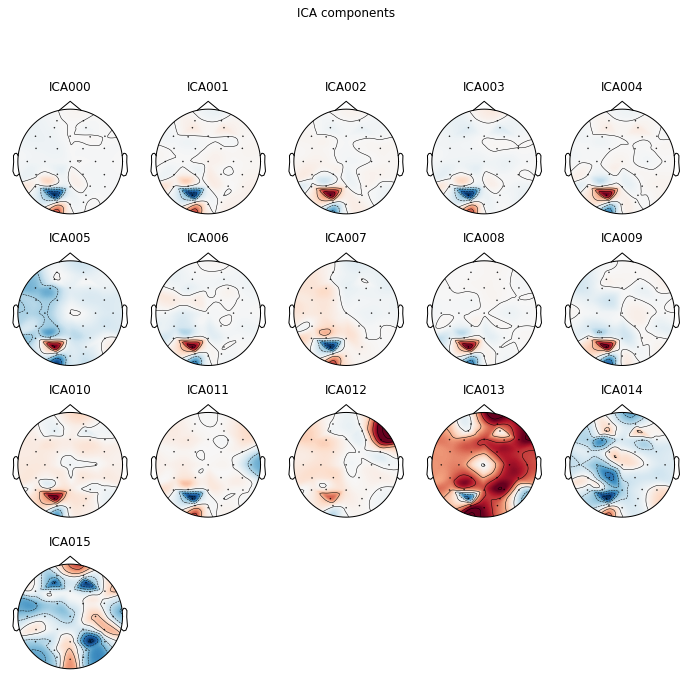

Creating RawArray with float64 data, n_channels=16, n_times=7494
    Range : 0 ... 7493 =      0.000 ...    29.972 secs
Ready.


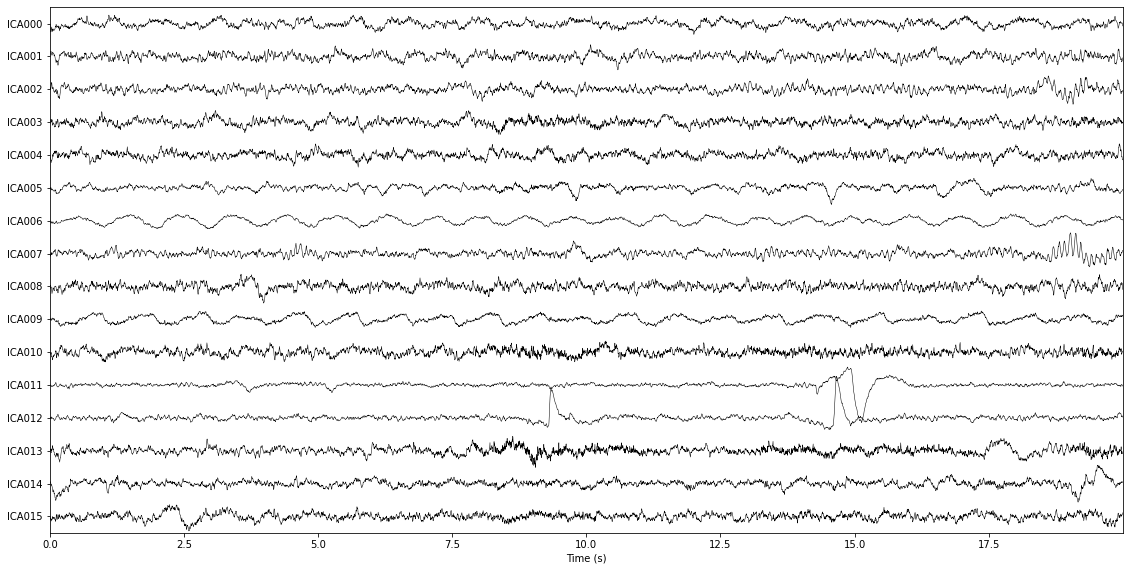

Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components


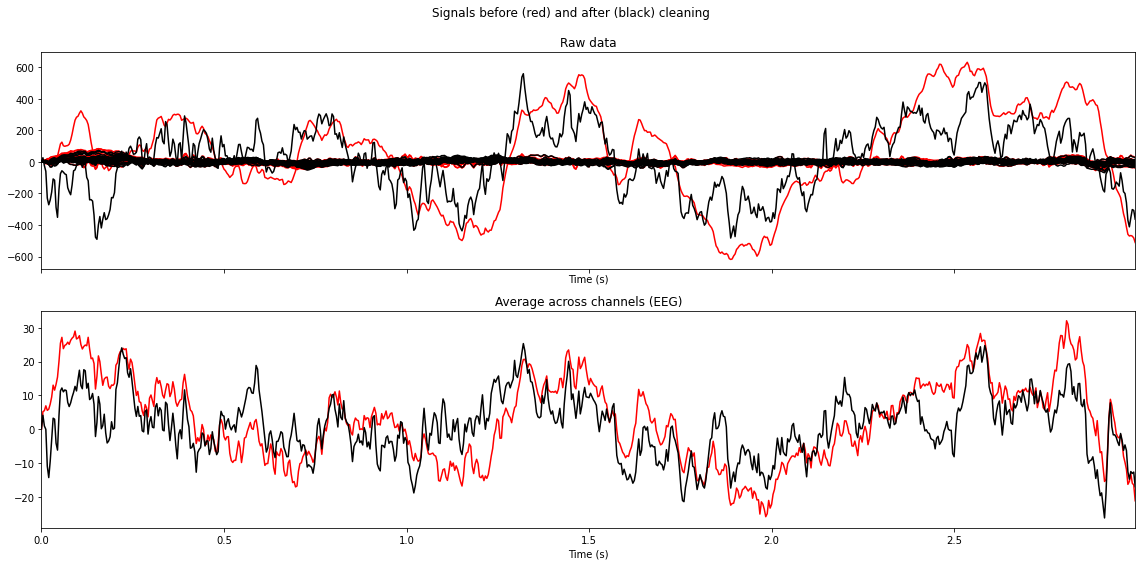

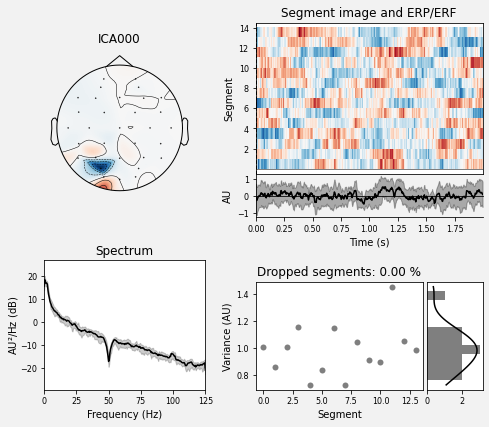

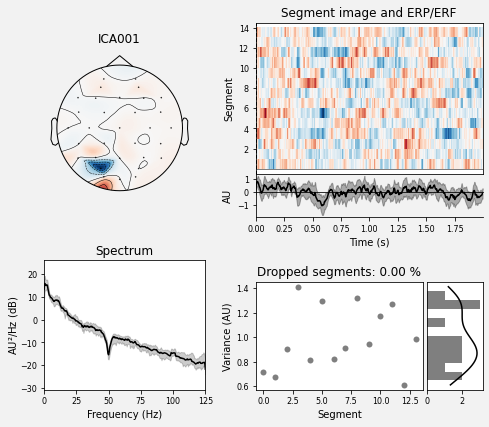

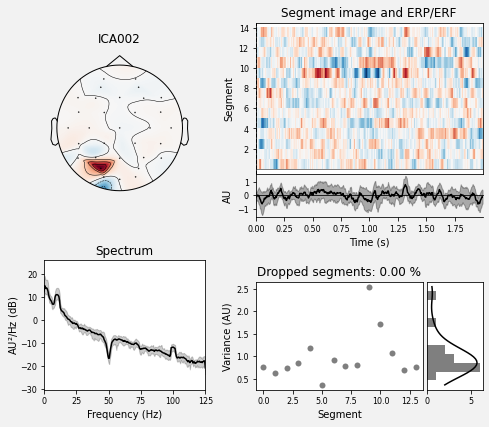

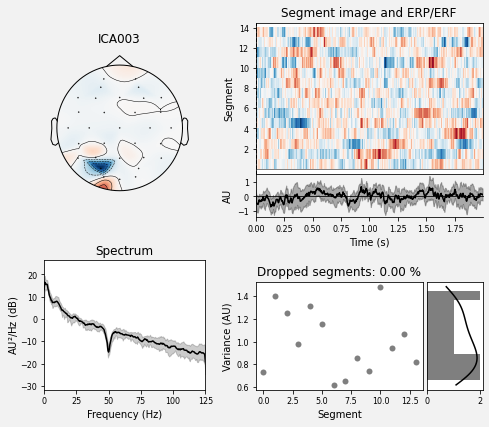

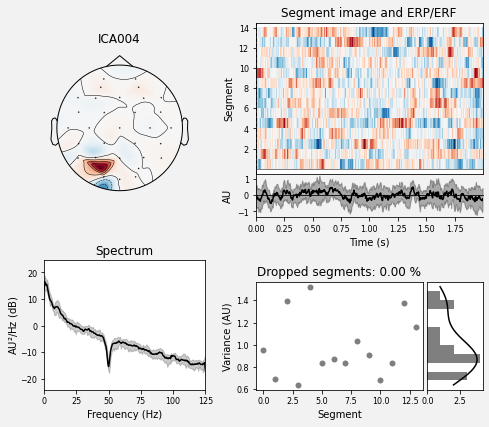

In [45]:
data = elt.load_data()
start, stop = elt.extract_trigger_intervals(data, 0)
data_trim = data[start:stop, :-1] #trigger is useless from now on
data_mne_filtered = elt.prepare_data(data_trim).filter(1.0, None)
ica = elt.run_ica(data_mne_filtered, 'fastica', 16)
elt.show_projection(data_mne_filtered, ica)

Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 0 ICA components
    Projecting back using 32 PCA components


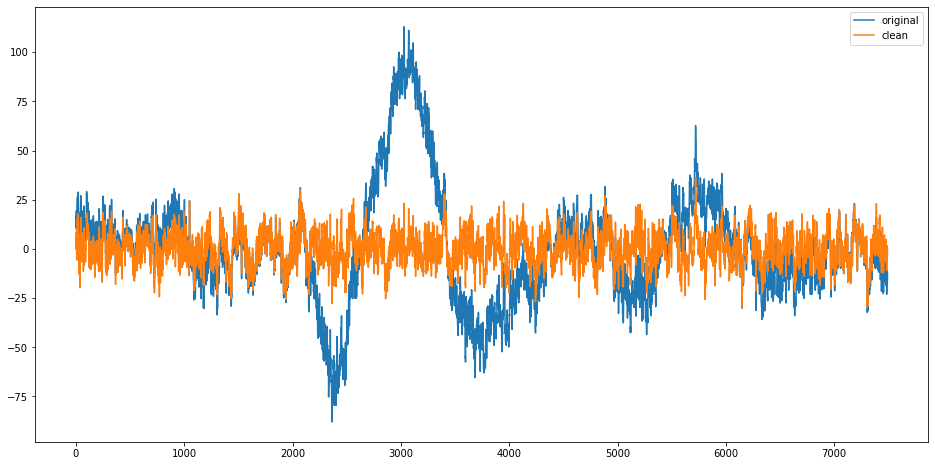

In [46]:
data_copy = data_mne_filtered.copy()
ica.apply(data_copy)
plt.plot(data_trim[:, 0], label='original')
plt.plot(data_copy.get_data()[0, :], label='clean')
plt.legend()